# WasmTreeDataset performances vs Graphy vs Sophia

More on the context
- https://github.com/BruJu/Portable-Reasoning-in-Web-Assembly
- https://github.com/BruJu/Portable-Reasoning-in-Web-Assembly/blob/master/notes/rustvsjs/CompareTarget.ipynb

We benchmark using the sophia_benchmark infrastructure the speed of retrieval of the second request for given S / SP / PO / POG on the PersonData database.

## Loading data

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [7]:
datasets = [
    ("Sophia Fast", ["sophia", "sophia_js"]),
    ("Sophia Light", ["sophia_lg", "sophia_js_lg"]),
    ("Sophia Tree", ["sophia_tree", "sophia_js_tree"]),
    ("Sophia Full", ["sophia_full", "sophia_js_full"]),
    ("Sophia Array", ["sophia_array", "sophia_js_array"]),
    ("Graphy", [None, "sophia_js_graphy"]),
    ("Web Tree", [None, "rust_wrapped"])
]

prefixes = "data/fillforeachwaskpack3size_" # This name is so stupid
queries = ["query", "query3", "query2", "query4"]
extension = ".csv"

def query_test(query):
    if query == "query" or query == "query1":
        return "<POG>"
    elif query == "query2":
        return "<SG>"
    elif query == "query3":
        return "<PO>"
    else:
        return "<S>"

## Compute average

In [8]:
data = {}

for query in queries:
    for dataset_kind in datasets:
        name = dataset_kind[0]
        list_of_files = dataset_kind[1]

        def read_file(filename):
            d = {}
            
            if filename is None:
                return d
            
            filename = prefixes + query + "-" + filename + extension

            with open(filename, 'r') as file:
                reader = csv.reader(file)

                is_first = True
                for row in reader:
                    if is_first:
                        is_first = False
                    else:
                        nb_of_quads = int(row[1])
                        if nb_of_quads not in d:
                            d[nb_of_quads] = []

                        #total_time = float(row[7]) + float(row[8])
                        total_time = float(row[7]) + float(row[8])
                        #total_time = float(row[7])
                        d[nb_of_quads].append(total_time)
        
            return d

        data[("Rust", name, query)] = read_file(list_of_files[0])
        data[("Wasm", name, query)] = read_file(list_of_files[1])

def avg(l):
    i = 0
    for x in l:
        i += x
    return i / len(l)

for key in data:
    for ds in data[key]:
        data[key][ds] = avg(data[key][ds])

In [9]:
import pprint as pp

for x in data:
    print(x)
    pp.pprint(data[x], indent=2)
    break

('Rust', 'Sophia Fast', 'query')
{ 10000: 0.00146701075,
  20000: 0.003037629,
  40000: 0.00632468125,
  80000: 0.0144280655,
  100000: 0.0165636755,
  1000000: 0.270090575}


In [16]:
def draw_plot(queries, graph_name, intermediates):
    if graph_name == "Web Tree":
        return

    plt.rcParams["figure.figsize"]=20,10
    
    def dd(query_name, p):
        for target in ['Rust', 'Wasm']:
            x = []
            y = []

            for entry in data:
                if entry[0] == target and entry[1] == graph_name and entry[2] == query_name:
                    for size in data[entry]:
                        x.append(size)
                        y.append(data[entry][size])

            qname = query_name
            if qname == "query":
                qname = "query1"

            p.loglog(x, y, label=target)
        
        if graph_name == "Sophia Tree":
            x = []
            y = []

            for entry in data:
                if entry[0] == target and entry[1] == "Web Tree" and entry[2] == query_name:
                    for size in data[entry]:
                        x.append(size)
                        y.append(data[entry][size])

            qname = query_name
            if qname == "query":
                qname = "query1"

            p.loglog(x, y, label="Web")
        
        p.legend()
    
    fig, axs = plt.subplots(2, 2, sharex='col', sharey='row')
    (p1, p2), (p3, p4) = axs
    
    dd(queries[0], p1)
    dd(queries[1], p2)
    dd(queries[2], p3)
    dd(queries[3], p4)
    print("Comparing " + graph_name + " Dataset on POG / PO then SG / S")
    
    axes = plt.gca()
    axes.set_ylim([10**-7, 1])
    p1.set_ylim([10**-7, 1])
    p2.set_ylim([10**-7, 1])
    p3.set_ylim([10**-7, 1])
    p4.set_ylim([10**-7, 1])
    plt.show()

## Plot drawing

We draw a plot for every dataset and query to compare the plot shape

- x = number of quads in the dataset
- y = time to answer in second

When using the `match` function a new dataset is created. Self means that the same dataset structure is used to wrap the new dataset, Array means that the created dataset is a simple array.

Comparing Sophia Fast Dataset on POG / PO then SG / S


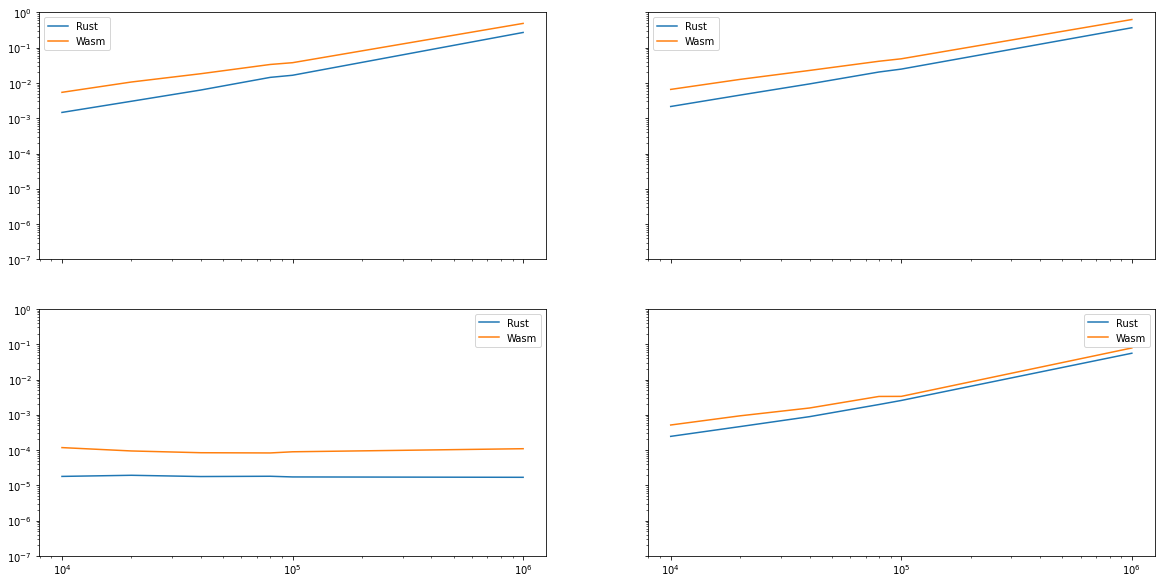

Comparing Sophia Light Dataset on POG / PO then SG / S


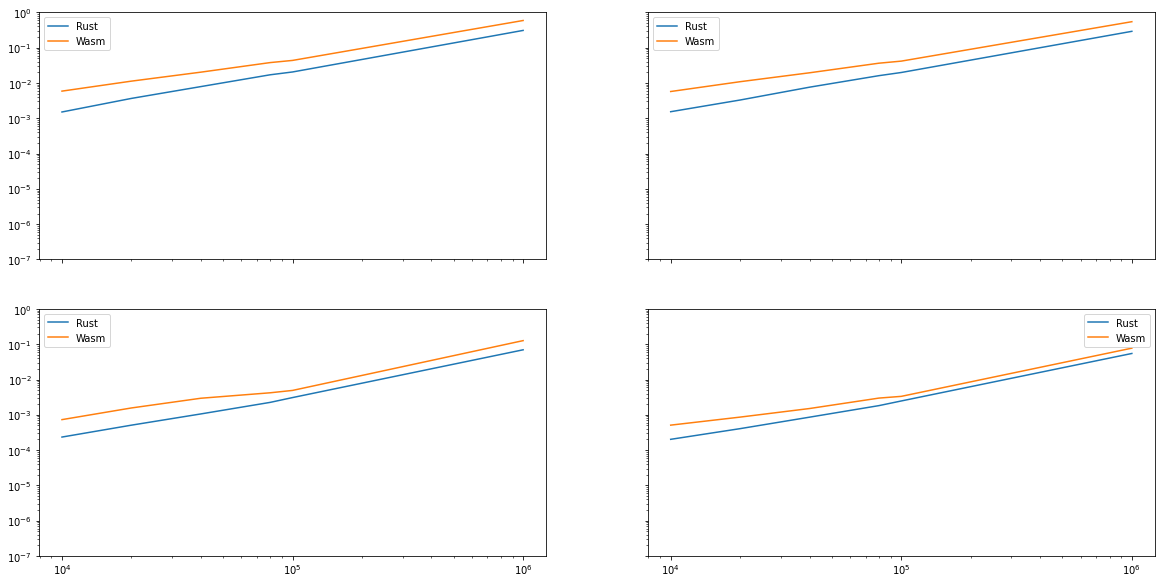

Comparing Sophia Tree Dataset on POG / PO then SG / S


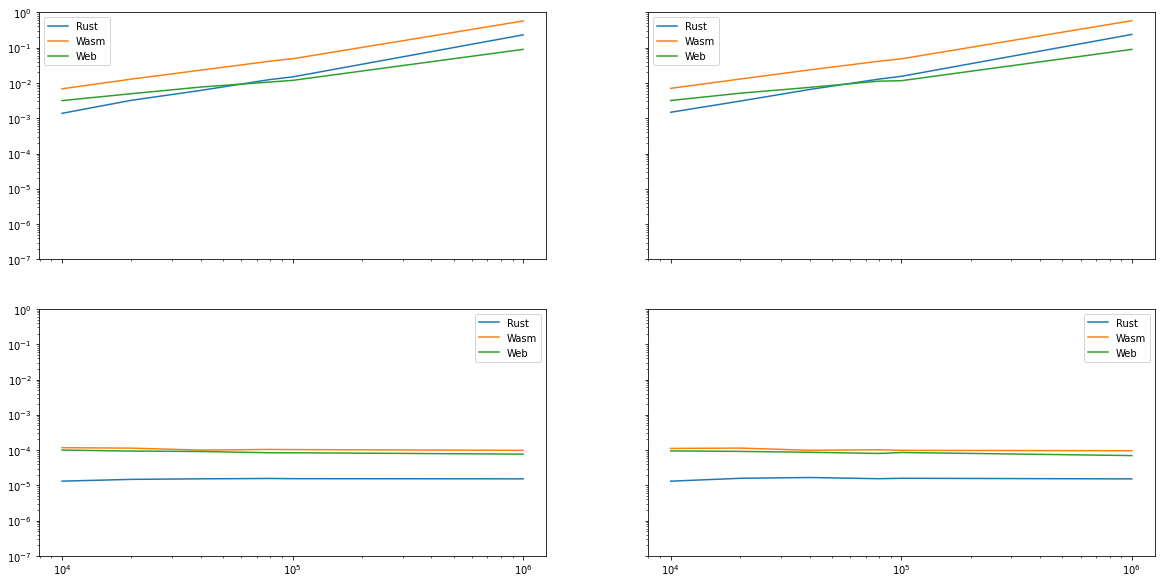

Comparing Sophia Full Dataset on POG / PO then SG / S


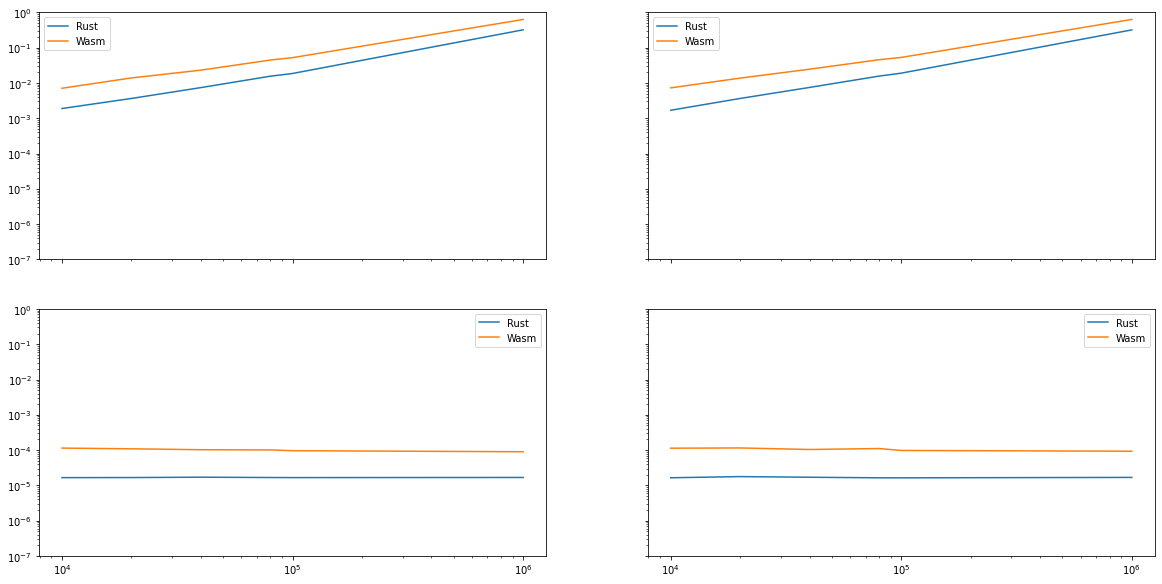

Comparing Sophia Array Dataset on POG / PO then SG / S


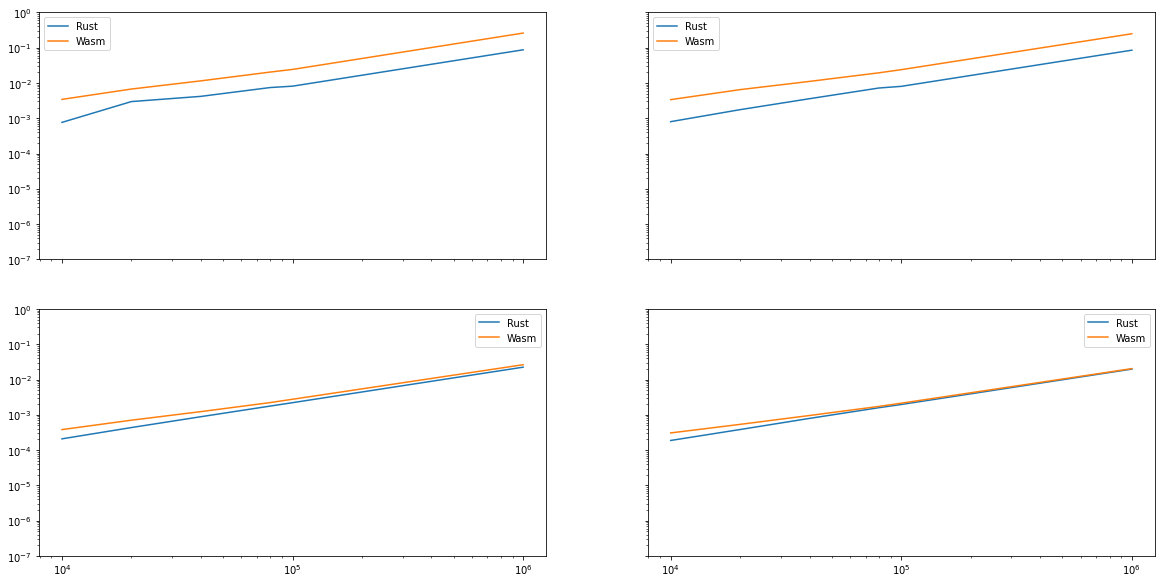

Comparing Graphy Dataset on POG / PO then SG / S


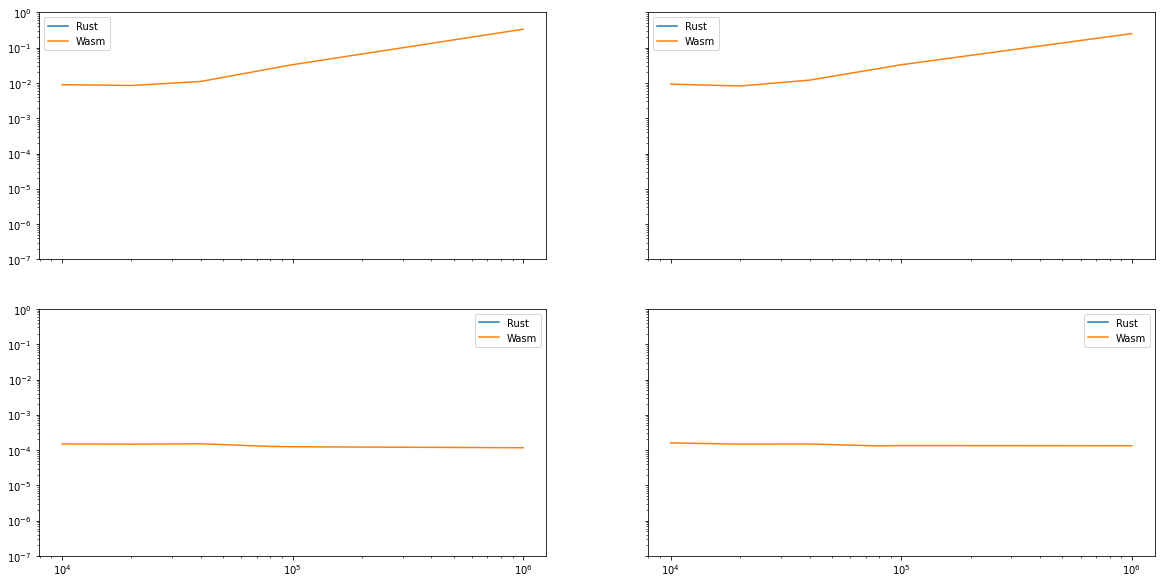

In [17]:
for dataset_type in datasets:
    draw_plot(["query", "query3", "query2", "query4"], dataset_type[0], ["Self", "Array"])

For the same query and datastructure, native Rust and Wasm exported datasets have the same plot, ie the same complexity.

## Comparing different datasets

A new draw plot function

In [23]:
def draw_plots(queries, datasets, targets):
    def make_title(q, d, t):
        if d == "Graphy":
            return "Graphy"
        
        if d == "Web Tree":
            return "Web Tree"
        
        zz = ""
        
        if len(queries) != 1:
            zz += q + " "        
        if len(datasets) != 1:
            zz += d + " "        
        if len(targets) != 1:
            zz += t + " "
        
        return zz
    
    
    for query in queries:
        for target in targets:
            for dataset in datasets:
                x = []
                y = []

                for entry in data:
                    if entry[2] == query and entry[1] == dataset and target == entry[0]:
                        for size in data[entry]:
                            x.append(size)
                            y.append(data[entry][size])
                
                if len(x) > 0:
                    plt.loglog(x, y, label=make_title(query, dataset, target))
        
    # plt.title("Comparing " + graph_name + " Dataset on " + qname)
    axes = plt.gca()
    axes.set_ylim(10**-7, 1)
    plt.legend()
    
    plt.show()
    
plt.rcParams["figure.figsize"]=10,5

## Web tree performances

### In NodeJS

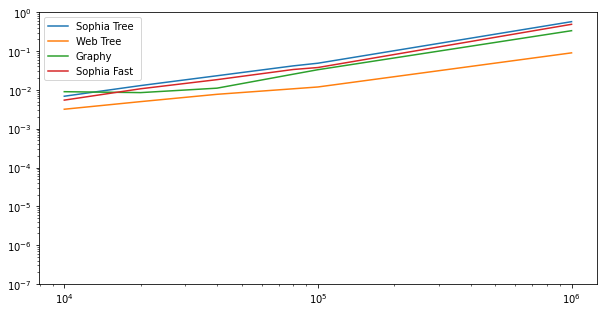

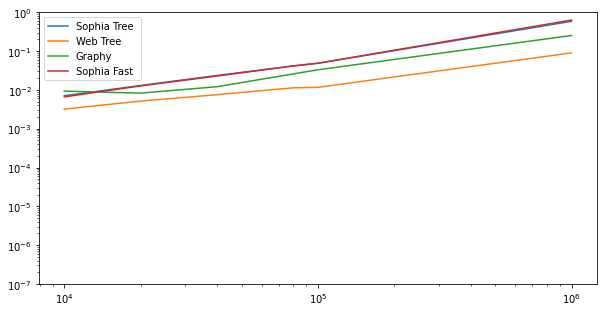

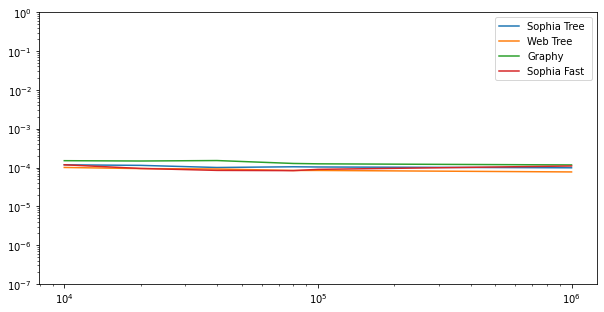

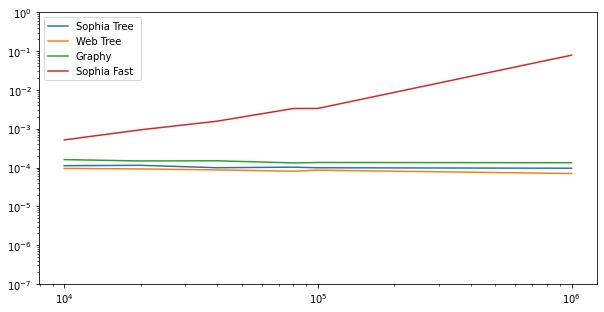

In [24]:
for q in queries:
    draw_plots([q], ["Sophia Tree", "Web Tree", "Graphy", "Sophia Fast"], ["Wasm"])

## vs Sophia

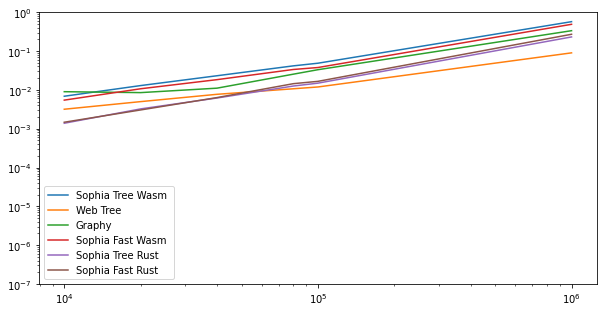

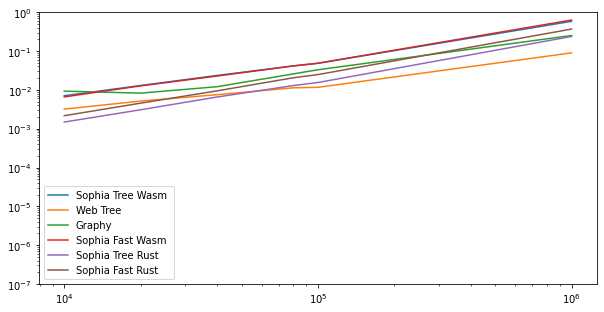

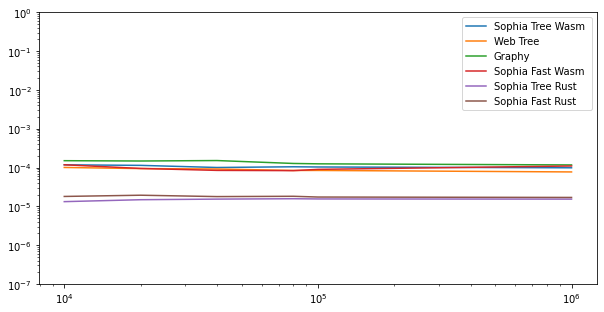

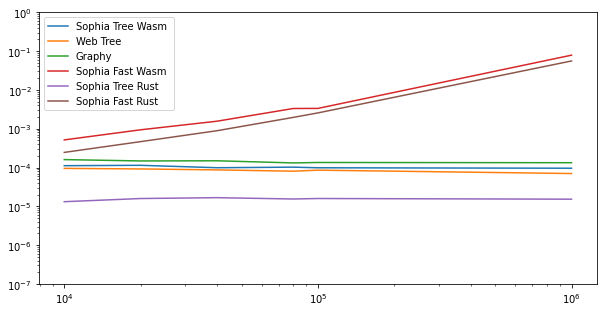

In [25]:
for q in queries:
    draw_plots([q], ["Sophia Tree", "Web Tree", "Graphy", "Sophia Fast"], ["Wasm", "Rust"])

~~Trees are awesome. Save the planet, plant trees~~

The concise method to store the indexmap and/or the lazyness of not being able to remove unused quad and/or the sharing of the indexmap let us be faster than native Sophia for big datasets.